In [53]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Get your data from [here.](https://www.kaggle.com/c/titanic/data)

In [54]:
master = pd.read_csv('./titanic/train.csv')

In [55]:
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [56]:
data = master[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
data

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


In [57]:
data = data.fillna(value = -1)

In [58]:
data = pd.concat([data,pd.get_dummies(data['Embarked'])],axis = 1).drop(columns = ['Embarked'])
data = pd.concat([data,pd.get_dummies(data['Sex'])],axis = 1).drop(columns = ['Sex'])

In [59]:
data

,Pclass,Age,SibSp,Parch,Fare,-1,C,Q,S,female,male
0,3,22.0,1,0,7.2500,0,0,0,1,0,1
1,1,38.0,1,0,71.2833,0,1,0,0,1,0
2,3,26.0,0,0,7.9250,0,0,0,1,1,0
3,1,35.0,1,0,53.1000,0,0,0,1,1,0
4,3,35.0,0,0,8.0500,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,0,0,0,1,0,1
887,1,19.0,0,0,30.0000,0,0,0,1,1,0
888,3,-1.0,1,2,23.4500,0,0,0,1,1,0
889,1,26.0,0,0,30.0000,0,1,0,0,0,1


In [60]:
d  = data.iloc[:,:].values
d[0]

array([ 3.  , 22.  ,  1.  ,  0.  ,  7.25,  0.  ,  0.  ,  0.  ,  1.  ,
        0.  ,  1.  ])

In [61]:
d_biased = np.c_[np.ones(len(d)),d]

In [62]:
d_biased

array([[ 1.,  3., 22., ...,  1.,  0.,  1.],
       [ 1.,  1., 38., ...,  0.,  1.,  0.],
       [ 1.,  3., 26., ...,  1.,  1.,  0.],
       ...,
       [ 1.,  3., -1., ...,  1.,  1.,  0.],
       [ 1.,  1., 26., ...,  0.,  0.,  1.],
       [ 1.,  3., 32., ...,  0.,  0.,  1.]])

In [63]:
truth = master['Survived'].values

# General ANN Structure

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

In [76]:
def create_model(inputsize):
    model = Sequential()
    model.add(Dense(units = 256, input_dim = inputsize, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 0.01), metrics=['accuracy'])
    return model
              

In [78]:
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_acc') > 0.8):   
            print("\nWe have reached %2.2f%% accuracy, so we will stopping training." %(logs.get('val_acc')*100))   
            self.model.stop_training = True

### Back Propogation



### Why Rectified Linear Unit?
Universal Approximation Theorem states that a feed forward Neural Network with Linear Output Layer and atleast one hidden layer with any "squashing" activation function(such as sigmoid or softmax) can approximate any borel measurable function from one finite dimensional space to another with any desired non-zero amount of error provided that the function is fiven enough hidden units.<br>
The universal approximation theorem have also been proven for wider class for activation function which includes the rectified linear unit.<br>
And we want to make our lives easy!


# Test Train Split

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(d, truth, test_size=0.20, random_state=42)

In [70]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(d_biased, truth, test_size=0.20, random_state=42)

# Training

## Predict Yes or No

In [71]:
m1 = create_model(11)
callbacks = myCallback()
h1 = m1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 20,batch_size = 32,verbose = 2,callbacks=[callbacks])

Train on 712 samples, validate on 179 samples
Epoch 1/20
 - 1s - loss: 1.4552 - acc: 0.5744 - val_loss: 0.6240 - val_acc: 0.5978
Epoch 2/20
 - 0s - loss: 0.6556 - acc: 0.6404 - val_loss: 0.6180 - val_acc: 0.5922
Epoch 3/20
 - 0s - loss: 0.6102 - acc: 0.6784 - val_loss: 0.6466 - val_acc: 0.5866
Epoch 4/20
 - 0s - loss: 0.6139 - acc: 0.6404 - val_loss: 0.6179 - val_acc: 0.6872
Epoch 5/20
 - 0s - loss: 0.5734 - acc: 0.6980 - val_loss: 0.5280 - val_acc: 0.7877
Epoch 6/20
 - 0s - loss: 0.5577 - acc: 0.6994 - val_loss: 0.5157 - val_acc: 0.7709
Epoch 7/20

We have reached 82.12% accuracy, so we will stopping training.
 - 0s - loss: 0.5013 - acc: 0.7683 - val_loss: 0.4468 - val_acc: 0.8212


In [73]:
m2 = create_model(12)
callbacks = myCallback()
h2 = m2.fit(Xb_train,yb_train,validation_data=(Xb_test,yb_test),epochs = 20,batch_size = 32,verbose = 2,callbacks=[callbacks])

Train on 712 samples, validate on 179 samples
Epoch 1/20
 - 1s - loss: 1.3370 - acc: 0.5857 - val_loss: 0.6519 - val_acc: 0.6983
Epoch 2/20
 - 0s - loss: 0.6235 - acc: 0.6699 - val_loss: 0.8766 - val_acc: 0.6369
Epoch 3/20
 - 0s - loss: 0.6584 - acc: 0.6194 - val_loss: 0.5705 - val_acc: 0.6704
Epoch 4/20
 - 0s - loss: 0.5882 - acc: 0.6924 - val_loss: 0.5712 - val_acc: 0.6704
Epoch 5/20
 - 0s - loss: 0.5785 - acc: 0.7261 - val_loss: 0.6041 - val_acc: 0.6816
Epoch 6/20
 - 0s - loss: 0.5412 - acc: 0.7542 - val_loss: 0.5308 - val_acc: 0.7430
Epoch 7/20
 - 0s - loss: 0.5665 - acc: 0.7795 - val_loss: 0.5436 - val_acc: 0.7709
Epoch 8/20
 - 0s - loss: 0.5408 - acc: 0.7612 - val_loss: 0.5965 - val_acc: 0.7821
Epoch 9/20
 - 0s - loss: 0.5438 - acc: 0.7879 - val_loss: 0.5045 - val_acc: 0.7598
Epoch 10/20
 - 0s - loss: 0.5080 - acc: 0.7654 - val_loss: 0.4881 - val_acc: 0.7709
Epoch 11/20
 - 0s - loss: 0.4761 - acc: 0.8062 - val_loss: 0.4661 - val_acc: 0.7877
Epoch 12/20
 - 0s - loss: 0.4743 - acc:

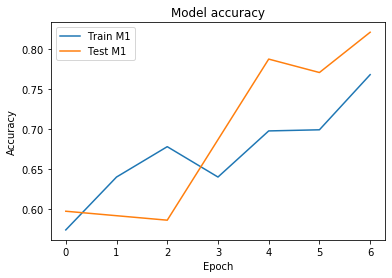

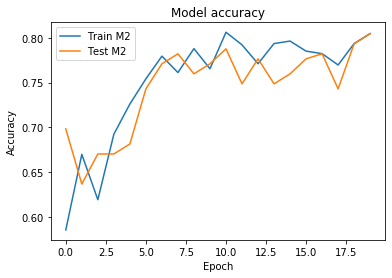

In [74]:
plt.plot(h1.history['acc'])
plt.plot(h1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train M1', 'Test M1'], loc='upper left')
plt.show()
plt.plot(h2.history['acc'])
plt.plot(h2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train M2', 'Test M2'], loc='upper left')
plt.show()
